<a href="https://colab.research.google.com/github/Gabriellemga/Python_Cursos_Alura/blob/main/Python_analise_dados_com_sql/Desafio_analise_de_dados_com_sql.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafios 01-02: explorando mais análises

Esse primeiro desafio vai ser constituído de duas análises, a primeira tem por objetivo calcular a receita total obtida com a venda de itens. Na tabela itens_pedidos, o valor total dos itens representa o cálculo da quantidade pelo valor unitário e pode ser considerado como a receita da venda.

Já a segunda análise visa identificar quais as 15 marcas que foram as mais pedidas por quantidades de venda. Busque mostrar essa lista em uma visualização, além de expor o nome das marcas.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect, text

In [3]:
url_itens_pedidos = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/itens_pedidos.csv'
url_pedidos = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/pedidos.csv'
url_produto = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/produtos.csv'
url_vendedores = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/vendedores.csv'

In [4]:
itens_pedidos = pd.read_csv(url_itens_pedidos)
pedidos = pd.read_csv(url_pedidos)
produtos = pd.read_csv(url_produto)
vendedores = pd.read_csv(url_vendedores)

In [5]:
engine = create_engine('sqlite:///:memory:')

In [6]:
produtos.to_sql('produtos', engine, index = False)
itens_pedidos.to_sql('itens_pedidos', engine, index = False)
pedidos.to_sql('pedidos', engine, index = False)
vendedores.to_sql('vendedores', engine, index = False)

5

In [7]:
inspector = inspect(engine)
print(inspector.get_table_names())

['itens_pedidos', 'pedidos', 'produtos', 'vendedores']


In [8]:
def sql_df (query):
    with engine.connect() as conexao:
      consulta = conexao.execute(text(query))
      dados = consulta.fetchall()

    return pd.DataFrame(dados, columns = consulta.keys())

In [9]:
sql_df('SELECT * FROM ITENS_PEDIDOS').head(3)

,id_nf,produto_id,pedido_id,quantidade,valor_unitario,valor_total,Estado,frete
0,1,41518,341,3,260,780,BR-BA,156.0
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,3,22407,1399,3,200,600,BR-PB,120.0


In [10]:
query = '''SELECT VALOR_TOTAL, SUM(VALOR_TOTAL) AS Receita
FROM ITENS_PEDIDOS
'''

df_receita = sql_df(query)
df_receita

,valor_total,Receita
0,780,45803930


In [11]:
sql_df('SELECT * FROM PRODUTOS').head(3)

,produto_id,produto,preco,marca,sku,Condicao
0,21244,Oculos Lente Azulada,1120,D&g Dolce & Gabbana,209297,Usado
1,9981,Bolsa Coral Saco,4000,Givenchy,278612,Usado
2,84176,Camisa Xadrez Verde,310,Joe Fresh,322482,Usado


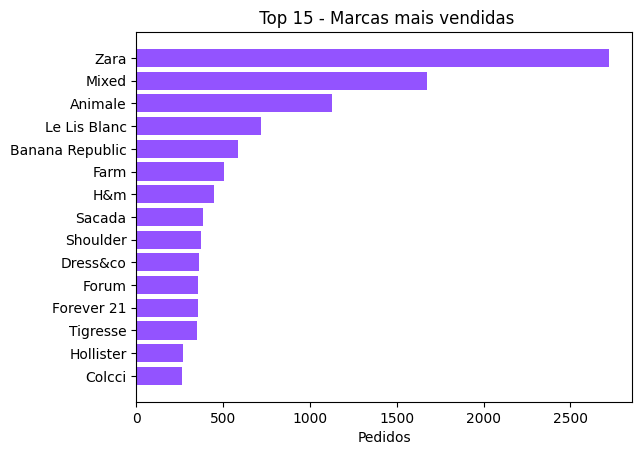

In [12]:
query = '''SELECT  PRODUTOS.MARCA ,  COUNT (*) AS Pedidos
FROM ITENS_PEDIDOS, PRODUTOS
WHERE ITENS_PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
GROUP BY PRODUTOS.MARCA
ORDER BY Pedidos DESC
LIMIT 15
'''

df_marcas = sql_df(query)

plt.barh(df_marcas['marca'], df_marcas['Pedidos'], color = '#9353FF')
plt.title(' Top 15 - Marcas mais vendidas')
plt.xlabel('Pedidos')
plt.gca().invert_yaxis()
plt.show()

# Desafios 03-04: exibindo diferentes resultados

Vamos aos desafios dessa aula, o primeiro é exibir os 10 produtos mais vendidos durante o ano de 2019, que podem ser representados em uma tabela.

Já o segundo será publicar a distribuição através dos meses da receita obtida em vendas no ano de 2021. Busque mostrar essa distribuição colocando o mês e sua receita correspondente na visualização.

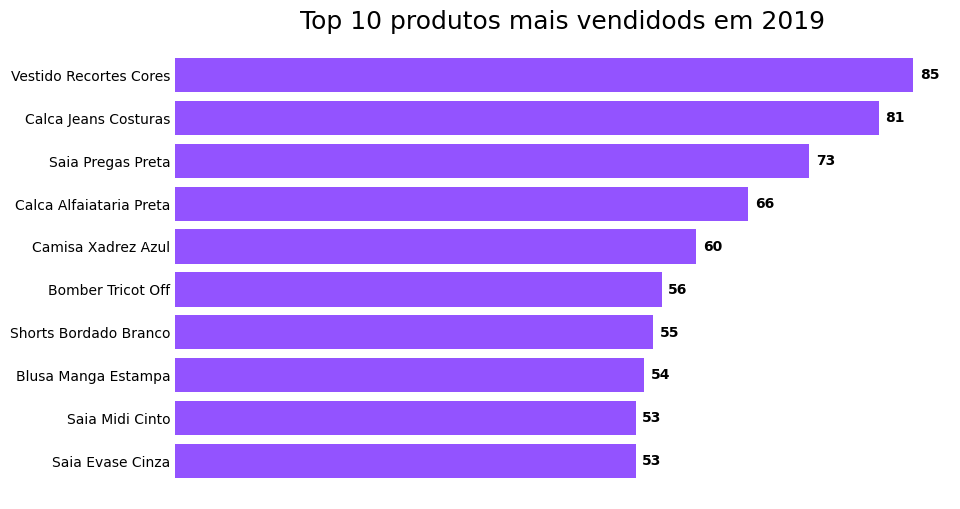

In [13]:
query = ''' SELECT PRODUTOS.PRODUTO, COUNT(PEDIDOS.PEDIDO_ID) AS 'Quantidade vendida'
FROM PEDIDOS, PRODUTOS
WHERE strftime('%Y', data_compra) = '2019' AND PRODUTOS.PRODUTO_ID = PEDIDOS.PRODUTO_ID
GROUP BY PRODUTOS.PRODUTO
ORDER BY COUNT(PEDIDOS.PEDIDO_ID) DESC
LIMIT 10
'''

top_10_2019 = sql_df(query)

fig, ax = plt.subplots(figsize = (10, 6 ))
ax.barh(top_10_2019['produto'], top_10_2019['Quantidade vendida'], color = '#9353FF')
ax.set_title('Top 10 produtos mais vendidods em 2019', fontsize = 18)
ax.invert_yaxis()
ax.set_frame_on(False)
ax.tick_params(axis="both", which="both", length=0)
ax.set_xticklabels([])



for i, valor in enumerate(top_10_2019['Quantidade vendida']):
    ax.text(valor + 3, i, valor, fontsize=10, fontweight='bold', ha='right', va='center')
plt.show()



In [14]:
query = ''' SELECT strftime('%m', data_compra) as 'Mês', SUM(PEDIDOS.TOTAL) AS 'Receita total'
FROM PEDIDOS
WHERE strftime('%Y', data_compra) = '2021'
GROUP BY strftime('%m', data_compra)
'''

sql_df(query)

,Mês,Receita total
0,01,2097109
1,02,1140729
2,03,51525


# Desafios 05 e 06: outras informações para a Meteora

A intenção da Meteora é iniciar sua ação no mês de dezembro em São Paulo, aproveitando as compras de natal para divulgar os produtos e lançar promoções para pedidos feitos nesse estado. Pensando nisso, vamos fornecer duas informações que podem contribuir na ação de dezembro.

A primeira informação é listar as marcas vendidas em São Paulo por quantidade de pedidos, que podem ser representadas em uma tabela.

Já a segunda informação é publicar os produtos que são mais vendidos na época de Natal no Brasil todo. Essa última informação é aplicada a todos os estados porque somente o estado de São Paulo pode não trazer uma quantidade relevante de informações.

In [15]:
query = '''SELECT PRODUTOS.MARCA, COUNT(*) AS 'Produtos vendidos'
FROM PRODUTOS
JOIN ITENS_PEDIDOS ON ITENS_PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
WHERE ITENS_PEDIDOS.ESTADO = 'BR-SP'
GROUP BY PRODUTOS.MARCA
ORDER BY COUNT(ITENS_PEDIDOS.PRODUTO_ID) DESC;
'''
sql_df(query)


,marca,Produtos vendidos
0,Zara,100
1,Mixed,58
2,Animale,44
3,Le Lis Blanc,26
4,Banana Republic,18
...,...,...
111,Topshop,1
112,Morena Rosa,1
113,Erre Erre,1
114,Bobô,1


In [23]:
query = '''SELECT PRODUTOS.PRODUTO, COUNT(*) AS Quantidade_vendas
FROM ITENS_PEDIDOS
JOIN PRODUTOS ON PRODUTOS.PRODUTO_ID = ITENS_PEDIDOS.PRODUTO_ID
JOIN PEDIDOS ON PEDIDOS.PEDIDO_ID = ITENS_PEDIDOS.PEDIDO_ID
WHERE strftime('%m',PEDIDOS.DATA_COMPRA)= '12'
GROUP BY PRODUTOS.PRODUTO
ORDER BY Quantidade_vendas DESC;
'''
sql_df(query)

,produto,Quantidade_vendas
0,Vestido Recortes Cores,30
1,Vestido Preto Franzido,26
2,Calca Jeans Costuras,26
3,Calca Alfaiataria Preta,26
4,Camisa Xadrez Azul,25
...,...,...
196,Sneaker Monograma Bege,6
197,Casaqueto Estampa Geometrica,6
198,Regata Renda Branca,5
199,Body Estampa Coracoes,5
